In [21]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [22]:
filepath = '/home/user/Desktop/env2/VAR/macro/macro_analysis.xlsx'
df = pd.read_excel(filepath,lineterminator='\n')
df=df[["Date","Libor 1M","Interest Rates","Inflation"]]
df.index=df['Date']
df=df.drop(['Date'],axis=1)
df.tail()

,Libor 1M,Interest Rates,Inflation
Date,,,
01-12-2020,0.08050,0.25,1.36
01-01-2021,0.08463,0.25,1.40
01-02-2021,0.07925,0.25,1.68
01-03-2021,0.07950,0.25,2.62
01-04-2021,0.07475,0.25,3.48


Text(0.5, 1.0, 'PLOT OF LIBOR AGAINST MACRO VARIABLES')

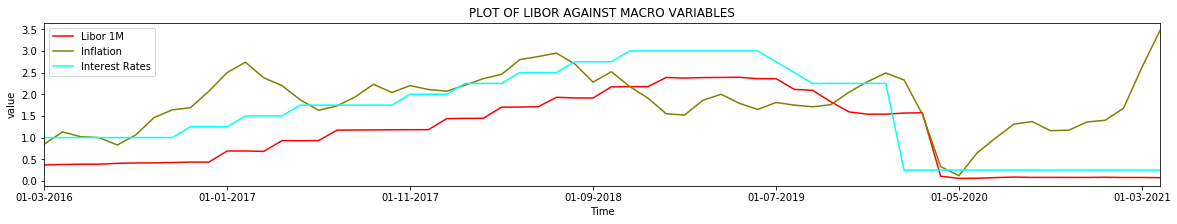

In [23]:
plt.rcParams["figure.figsize"] = (20,3)
df["Libor 1M"].plot(color="red",legend=True)
df["Inflation"].plot(color="olive",legend=True)
df["Interest Rates"].plot(color="cyan",legend=True)
plt.xlabel("Time")
plt.ylabel("value")
plt.title("PLOT OF LIBOR AGAINST MACRO VARIABLES")

In [24]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df["Interest Rates"], df["Libor 1M"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.913


In [25]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df["Inflation"], df["Libor 1M"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.434


In [27]:
# df=df[["Libor 1M","Inflation"]]
df=df[["Libor 1M","Interest Rates"]]
df.tail()

,Libor 1M,Interest Rates
Date,,
01-12-2020,0.08050,0.25
01-01-2021,0.08463,0.25
01-02-2021,0.07925,0.25
01-03-2021,0.07950,0.25
01-04-2021,0.07475,0.25


In [28]:
#GRANGER'S CAUSALITY TEST TO DETERMINE THE PRESENCE OF RELATIONSHIPS BETWEEN TIME SERIES.
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Libor 1M_x,Interest Rates_x
Libor 1M_y,1.0,0.0
Interest Rates_y,0.0,1.0


In [29]:
#TRAIN-TEST SPLIT

nobs = int(0.1*len(df))
print(nobs)
df_train, df_test = df.iloc[:-nobs,:], df.iloc[-nobs:,:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

6
(56, 2)
(6, 2)


In [30]:
#AUGMENTED DICKEY-FULLER TEST FOR STATIONARITY

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
          
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Libor 1M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0777
 No. Lags Chosen       = 11
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.2536. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Interest Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.752
 No. Lags Chosen       = 0
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.8328. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [31]:
# 1st difference
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Libor 1M" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8547
 No. Lags Chosen       = 0
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Interest Rates" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0366
 No. Lags Chosen       = 0
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [33]:
#SELECT ORDER OF THE VAR MODEL [P]

model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)


Lag Order = 1
AIC :  -5.1966887366604215
Lag Order = 2
AIC :  -8.07421028543493
Lag Order = 3
AIC :  -8.1425110994764
Lag Order = 4
AIC :  -8.04165328811502
Lag Order = 5
AIC :  -7.893592787133138
Lag Order = 6
AIC :  -7.884827720050703
Lag Order = 7
AIC :  -8.080353325285575
Lag Order = 8
AIC :  -8.968426630221213
Lag Order = 9
AIC :  -9.056884010494942


/home/user/Desktop/env2/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [34]:
#TRAINING THE MODEL

model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Apr, 2021
Time:                     14:16:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.61718
Nobs:                     52.0000    HQIC:                  -7.94111
Log likelihood:           78.1357    FPE:                0.000291864
AIC:                     -8.14251    Det(Omega_mle):     0.000226717
--------------------------------------------------------------------
Results for equation Libor 1M
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.007814         0.006760            1.156           0.248
L1.Libor 1M              -0.405073         0.133836           -3.027           0.002
L1.Interest Rates         0.000565       

In [35]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
print(df_differenced)
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3
            Libor 1M  Interest Rates
Date                                
01-04-2016   0.01120            0.00
01-05-2016   0.00670            0.00
01-06-2016  -0.00030            0.00
01-07-2016   0.02060            0.00
01-08-2016   0.00830            0.00
01-09-2016   0.00171            0.00
01-10-2016   0.00822            0.00
01-11-2016   0.01023            0.25
01-12-2016  -0.00034            0.00
01-01-2017   0.25622            0.00
01-02-2017   0.00067            0.25
01-03-2017  -0.00944            0.00
01-04-2017   0.24833            0.00
01-05-2017  -0.00333            0.25
01-06-2017   0.00444            0.00
01-07-2017   0.24056            0.00
01-08-2017   0.00389            0.00
01-09-2017   0.00166            0.00
01-10-2017   0.00278            0.00
01-11-2017   0.00222            0.25
01-12-2017   0.00028            0.00
01-01-2018   0.25500            0.00
01-02-2018   0.00625            0.25
01-03-2018   0.00250            0.00
01-04-2018   0.25563            0.00

array([[ 0.01237,  0.     ],
       [-0.00775,  0.     ],
       [ 0.0005 ,  0.     ]])

In [36]:
# Forecast
od=1
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_'+str(od)+'d')
df_forecast

,Libor 1M_1d,Interest Rates_1d
Date,,
01-11-2020,0.007742,-0.015890
01-12-2020,0.004499,-0.010628
01-01-2021,-0.005872,-0.012975
01-02-2021,-0.002946,-0.011210
01-03-2021,-0.004415,-0.012481
01-04-2021,-0.003457,-0.013928


In [37]:
#INVERT TRANSFORMATION TO GET REAL FORECAST

def invert_transformation(df_train, df_forecast, difference):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if difference==2:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
            # Roll back 1st Diff
            df_fc[str(col)+' forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
        elif difference==1:
            df_fc[str(col)+' forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc



df_results_all = invert_transformation(df_train, df_forecast, od)
df_results=copy.deepcopy(df_results_all)
columns=df_results_all.columns
for col in columns:
    if len(col.split())==1:
        df_results.drop(col,axis=1,inplace=True)
print(df_results)
# df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
#                    'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

            Libor 1M_1d  Interest Rates_1d  Libor 1M forecast  \
Date                                                            
01-11-2020     0.007742          -0.015890           0.089492   
01-12-2020     0.004499          -0.010628           0.093991   
01-01-2021    -0.005872          -0.012975           0.088120   
01-02-2021    -0.002946          -0.011210           0.085174   
01-03-2021    -0.004415          -0.012481           0.080759   
01-04-2021    -0.003457          -0.013928           0.077301   

            Interest Rates forecast  
Date                                 
01-11-2020                 0.234110  
01-12-2020                 0.223481  
01-01-2021                 0.210507  
01-02-2021                 0.199297  
01-03-2021                 0.186816  
01-04-2021                 0.172888  


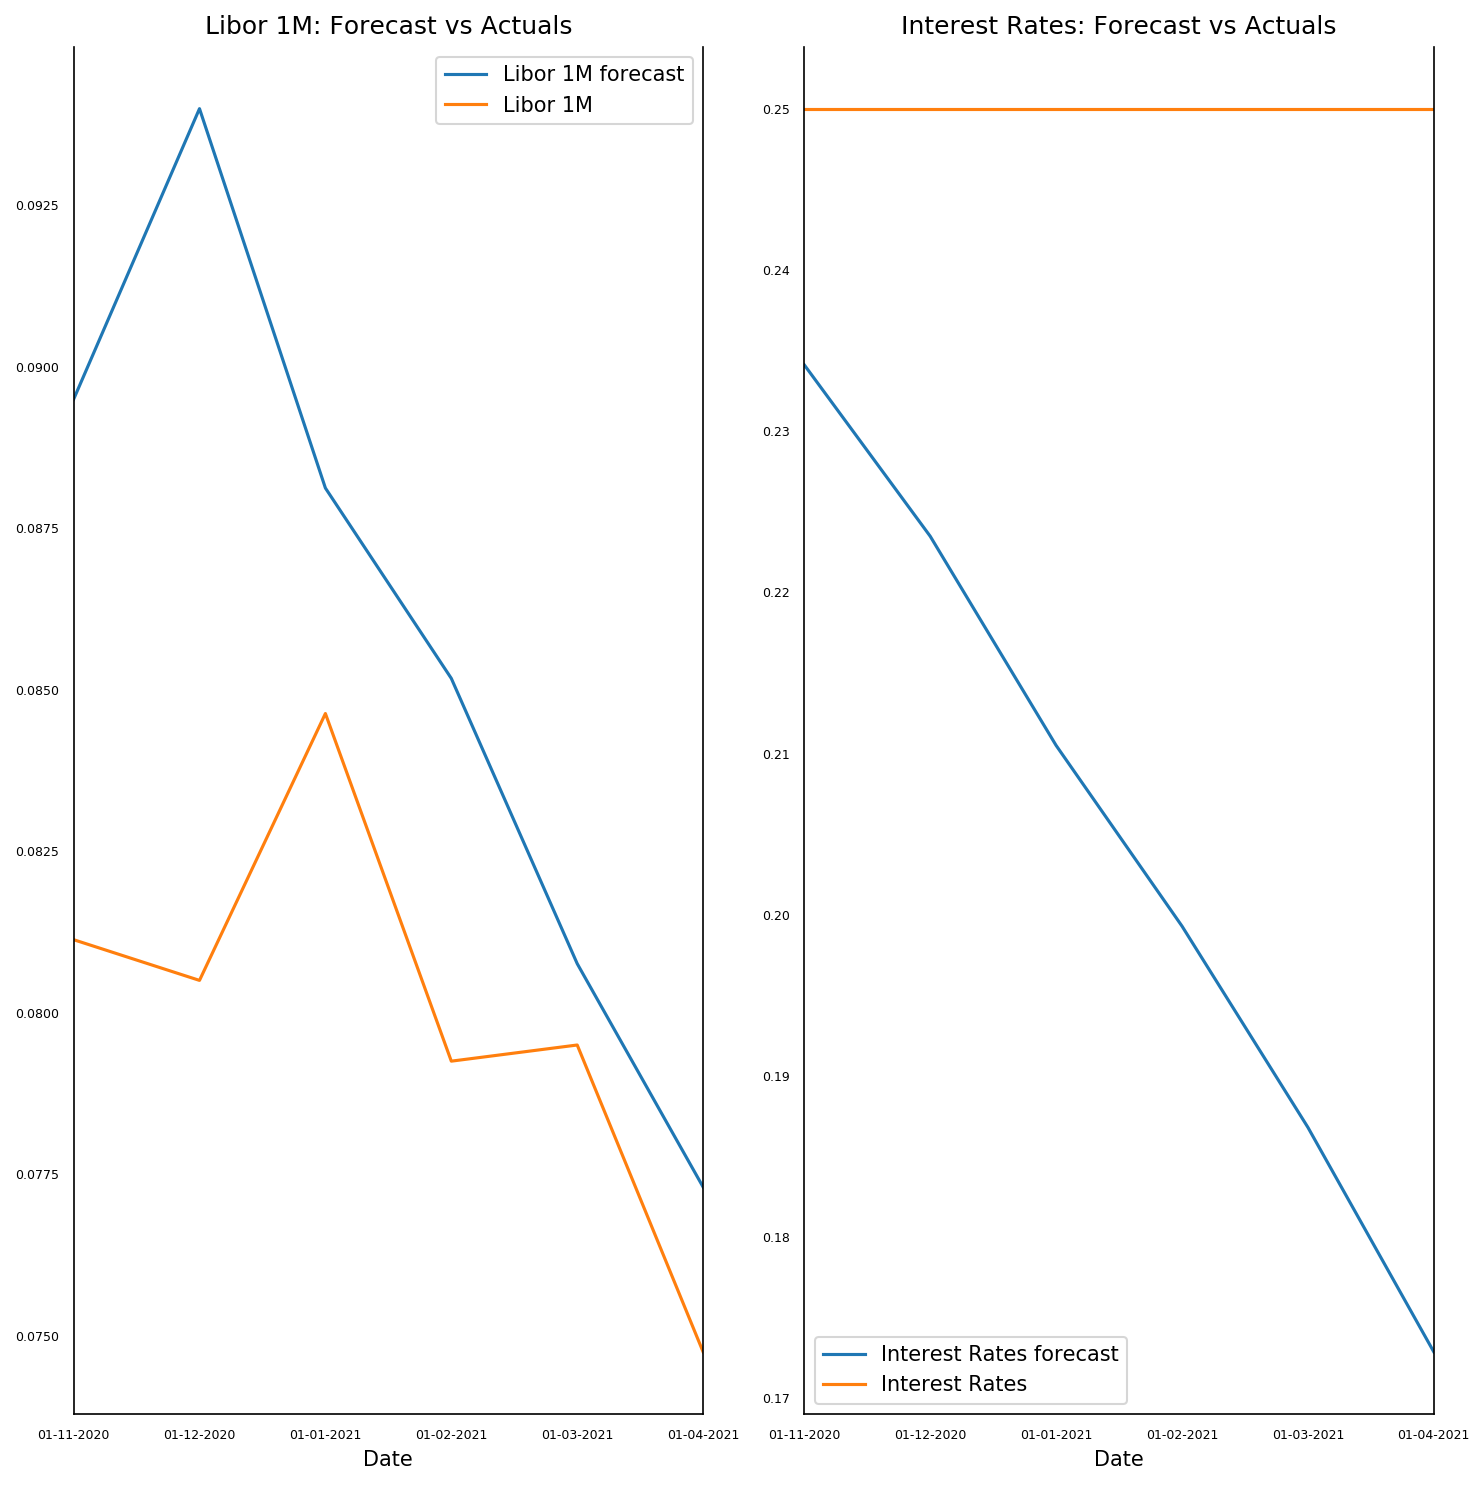

In [38]:
#PLOT OF ACTUAL VS FORECAST

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+' forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [39]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'rmse':rmse})
columns=df_train.columns
for col in columns:
    print('Forecast Accuracy of: '+str(col))
    accuracy_prod = forecast_accuracy(df_results[str(col)+' forecast'].values, df_test[str(col)])
    for k, v in accuracy_prod.items():
        print(k, ': ', round(v,4))
# print('Forecast Accuracy of: rgnp')
# accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: pgnp')
# accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: ulc')
# accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: gdfco')
# accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: gdf')
# accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: gdfim')
# accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: gdfcf')
# accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: gdfce')
# accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

Forecast Accuracy of: Libor 1M
rmse :  0.0072
Forecast Accuracy of: Interest Rates
rmse :  0.05
